In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from matplotlib.animation import FuncAnimation, writers

from tqdm import tqdm


%matplotlib inline

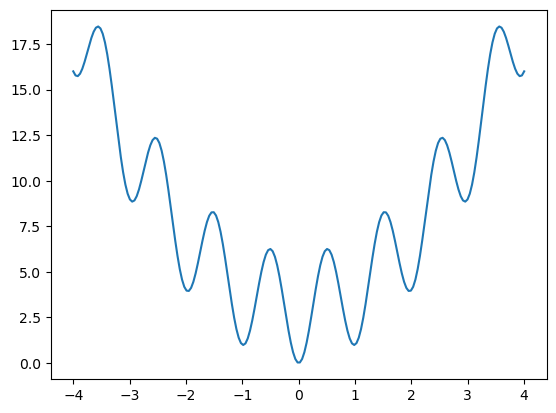

In [2]:
def rastrian_function(x, A):
    return A + x ** 2 - A * torch.cos(2 * torch.pi * x)

rast1 = lambda x: rastrian_function(x, 3)

# X = np.linspace(-4, 4, 200)
X = torch.linspace(-4, 4, 200)
y = [rast1(x) for x in X]

plt.plot(X,y)

plt.show()

##### run_optimizer

In [81]:
from torch.autograd import Variable

x_traj = []
A=3.0

x_list = []

def generate_random(upper, lower, shape):
    return lower + torch.rand(shape) * (upper - lower)

def run_optimize(N, objective, optimizer, early_stop_norm=1e-4, verbose=False):
    x_traj = []
    
    x = generate_random(-4, 4, N)
    if verbose: print("Initial condition:", x)
    x.requires_grad = True
    

    optim = optimizer([x])

    # Optimize the objective function
    for _ in range(int(1e4)):
        y = torch.sum(objective(x)) # summation doesn't affect the gradient
        optim.zero_grad()
        y.backward()
        
        # If the gradient is small, early stop
        if x_traj and np.linalg.norm(x.detach().numpy() - x_traj[-1]) < early_stop_norm:
            if verbose: print("Stopping gradient:", x.grad)
            break
            
        x_traj.append(x.detach().numpy().copy())
        
        optim.step()
    
    return x_traj

optimizer = partial(torch.optim.SGD, lr=1e-4)
x_traj = run_optimize(2, rast1, optimizer)


##### plot_result

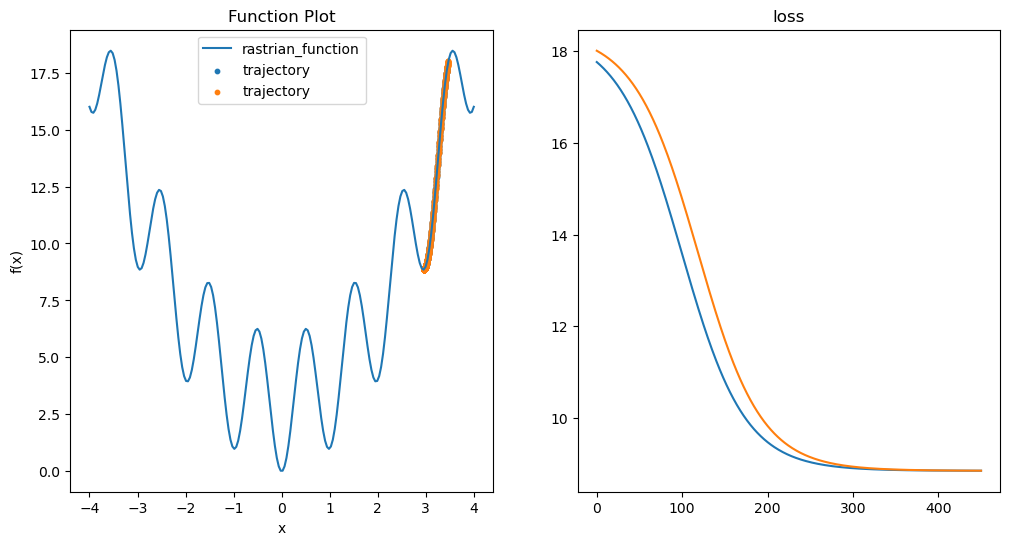

In [82]:
# Generate the function plot
def plot_function(ax, func, linspace, **kwargs):
    ax.plot(linspace, func(linspace), **kwargs)

def plot_result(x_traj, objective):

    fig, ax = plt.subplots(1,2, figsize=(12, 6))

    plot_function(ax[0], 
                  rast1, 
                  torch.linspace(-4, 4, 200),
                  label='rastrian_function')
    # ax[0].plot(x, y, label='rastrian_function')

    # Plot the trajectory points
    x_traj = torch.tensor(np.array(x_traj))
    y_traj = rast1(x_traj)

    for i in range(len(x_traj[0])):
        ax[0].scatter(x_traj[:, i], y_traj[:, i], label='trajectory', s=10)

    # Add labels and title
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('f(x)')
    ax[0].set_title('Function Plot')

    # Add legend
    ax[0].legend()

    ax[1].plot(y_traj)
    ax[1].set_title("loss")

    # Show the plot
    plt.show()

plot_result(x_traj, rast1)

##### Gif plotting

In [8]:
from IPython.display import HTML

# Generate the function plot
def plot_animate(x_traj):
    fig, ax = plt.subplots()

    def animation_function(t, x_traj):
        ax.cla()

        plot_function(ax, 
                      rast1, 
                      torch.linspace(-4, 4, 100),
                      label='rastrian_function')

        # Plot the trajectory points
        x_traj = torch.tensor(np.array(x_traj))
        y_traj = rast1(x_traj)

        for i in range(len(x_traj[0])):
            ax.scatter(x_traj[t, i], y_traj[t, i], label='trajectory', s=20)

        # Add labels and title
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.set_title('Function Plot')


    def init():
        ax.set_xlim(-4, 4)

    print("Total number of frames:", len(x_traj))
    animation = FuncAnimation(fig, partial(animation_function, x_traj=x_traj), frames = np.arange(len(x_traj)),
                              interval = 100, blit=False)

    animation.save("func.gif")
    return animation

# animation = plot_animate(x_traj)
# HTML(animation.to_html5_video())


## Experiments

In [89]:
# Do the experiment

def experiment(
    N,
    objective,
    optimizer,
    sample_size,
    optimum,
    tol,
):

    success = 0

    x_last = []

    losses = []

    for _ in tqdm(range(sample_size)):
        x_traj = run_optimize(N, objective, optimizer)
        x_last.append(x_traj[-1])
        losses.append(objective(torch.tensor(x_traj[-1])))
        if np.linalg.norm(x_traj[-1] - optimum) < tol:
            success += 1
    print("The sucess rate is", success/sample_size)
    
    return {
        'x_last': x_last,
        'losses': losses
    }

optimizer = partial(torch.optim.SGD, lr=1e-4)
result = experiment(1, rast1, optimizer, int(1e4), 0, 0.1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:09<00:00, 52.75it/s]

The sucess rate is 0.1224


In [7]:
def get_min_for_independent_trials(losses, r):
    losses = torch.tensor(losses)
    cut = len(losses) // r
    losses = losses[:r * cut]
    reshaped_loss = losses.reshape(r, -1)
    value, _ = torch.min(reshaped_loss, dim=0)
    return torch.mean(value)


average_loss = get_min_for_independent_trials(result['losses'], 3)
print("The average loss of independent trials (groups of 3) is", average_loss.item())

The average loss of independent trials (groups of 3) is 1.5595097541809082


In [58]:


class PEDS_SGD(torch.optim.SGD):
    def __init__(self, *args, **kwargs):
        if 'alpha' in kwargs:
            self.alpha = kwargs['alpha']
            del kwargs['alpha']
        else:
            self.alpha = 1
        super(PEDS_SGD, self).__init__(*args, **kwargs)
        
    
    def step(self):
        for group in self.param_groups:
            for param in group['params']:
                param.grad.fill_(torch.mean(param.grad))
                # param.grad.fill_(0)
                N = param.numel()
                Omega1 = torch.full((N, N), 1.0/N)
                param.grad.add_(torch.matmul(self.alpha * (torch.eye(N) - Omega1), param))
        super(PEDS_SGD, self).step()
                # param.add_(param.grad)



In [85]:
len(x_traj[::step])

103

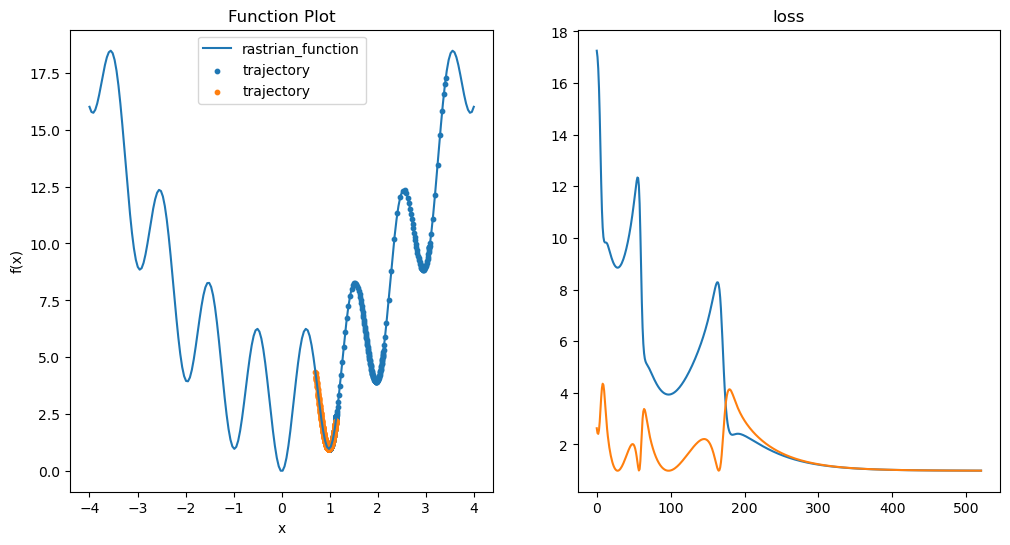

Total number of frames: 105


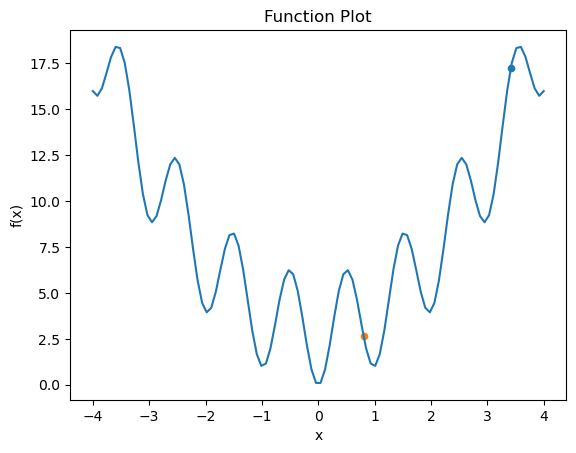

In [86]:
optimizer = partial(PEDS_SGD, alpha=1, lr=1e-2)
x_traj = run_optimize(2, rast1, optimizer)
plot_result(x_traj, rast1)

step = len(x_traj)//100
animation = plot_animate(x_traj[::step])

In [9]:
result = experiment(3, rast1, PEDS_SGD, int(1e2), 0, 0.1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.30it/s]

The sucess rate is 0.42


In [10]:

average_loss = np.mean([i.numpy() for i in result['losses']]) 
print("The average loss for PEDS for N=3 is", average_loss)

The average loss for PEDS for N=3 is 1.406149
